### 로봇 엔코더 데이터 불러와서 정리하고 보간하기

In [4]:
import os
import pandas as pd
import numpy as np
from datetime import datetime

from scipy.interpolate import interp1d

file_folder = "/home/najo/NAS/DIP/datasets/meca_insertion/vla_dataset3_hand2"
file_path = 'robot_data.txt'
full_path = os.path.join(file_folder, file_path)

# 1. 데이터 로딩
df = pd.read_csv(full_path, skiprows=1, header=None)
df.columns = [
    'timestamp',
    'j1', 'j2', 'j3', 'j4', 'j5', 'j6',
    'x', 'y', 'z', 'rx', 'ry', 'rz'
]

# 2. 결과를 저장할 리스트
interpolated_rows = []

# 3. 구간별 보간
for i in range(len(df) - 1):
    t0, t1 = df.loc[i, 'timestamp'], df.loc[i+1, 'timestamp']
    if t1 - t0 < 1e-6:
        continue  # 중복시간 방지

    # 시간 간격 내 보간용 timestamp 생성 (10ms 간격)
    interp_ts = np.round(np.arange(t0, t1, 0.01), 5)

    # 두 지점 사이 값 추출
    y0 = df.iloc[i, 1:].values.astype(float)
    y1 = df.iloc[i+1, 1:].values.astype(float)

    interp_data = np.vstack([y0, y1])

    # 시간 배열 (시작, 끝)
    time_segment = [t0, t1]

    # 보간기 생성: 각 컬럼별로 개별 spline2차
    f_interp = interp1d(
        time_segment, interp_data, axis=0,
        kind='linear', fill_value='extrapolate'
    )

    # 보간 수행
    interpolated_vals = f_interp(interp_ts)

    # 결과 합치기
    for ts, vals in zip(interp_ts, interpolated_vals):
        interpolated_rows.append([ts] + list(vals))

# 4. 마지막 지점 추가
last_row = df.iloc[-1].tolist()
interpolated_rows.append(last_row)

# 5. DataFrame으로 변환
columns = df.columns.tolist()
df_interp = pd.DataFrame(interpolated_rows, columns=columns)

# 6. datetime 추가
df_interp['datetime'] = df_interp['timestamp'].apply(lambda ts: datetime.fromtimestamp(ts))

# 7. 정렬 보장
df_interp.sort_values('timestamp', inplace=True)

# 결과 확인
print(df_interp[['timestamp', 'datetime']].head(10))

# CSV 저장
csv_path = os.path.join(file_folder, "robot_data_interpolated.csv")
df_interp.to_csv(csv_path, index=False)

print(f"✅ 보간 결과 저장 완료:\n- CSV: {csv_path}")

      timestamp                datetime
0  1.747201e+09 2025-05-14 14:36:09.301
1  1.747201e+09 2025-05-14 14:36:09.311
2  1.747201e+09 2025-05-14 14:36:09.321
3  1.747201e+09 2025-05-14 14:36:09.331
4  1.747201e+09 2025-05-14 14:36:09.341
5  1.747201e+09 2025-05-14 14:36:09.351
6  1.747201e+09 2025-05-14 14:36:09.361
7  1.747201e+09 2025-05-14 14:36:09.371
8  1.747201e+09 2025-05-14 14:36:09.381
9  1.747201e+09 2025-05-14 14:36:09.391
✅ 보간 결과 저장 완료:
- CSV: /home/najo/NAS/DIP/datasets/meca_insertion/vla_dataset3_hand2/robot_data_interpolated.csv


Searching for timestamp: 1747201050.89 (front, leftcam)


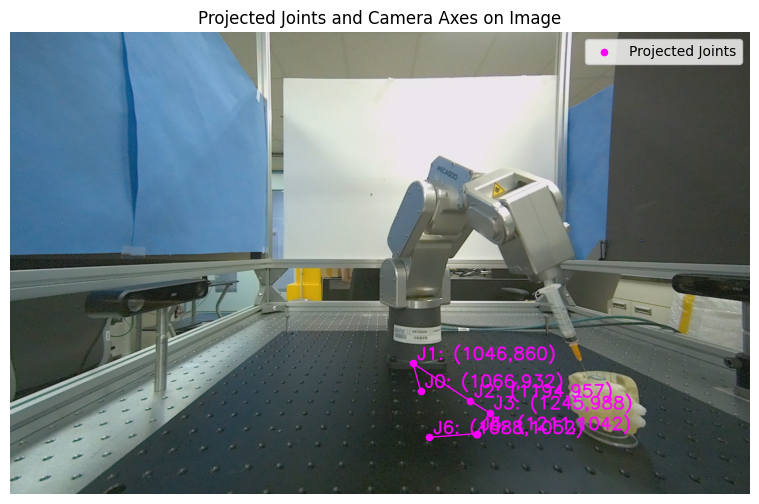

In [ ]:
import os
import json
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ---------------------- ArUco 결과 불러오기 ----------------------
aruco_path = './aruco_pose_summary2.json'
with open(aruco_path, 'r') as f:
    aruco_results_all = json.load(f)

# ---------------------- 실행부 ----------------------
image_path = "/home/najo/NAS/DIP/datasets/meca_insertion/vla_dataset_insertion_250514/front/zed_41182735_left_1747201050.893.jpg"
data_path = "/home/najo/NAS/DIP/datasets/meca_insertion/vla_dataset_insertion_250514/robot_data_interpolated.csv"
df = pd.read_csv(data_path)

# 이미지 파일명에서 뷰, 캠, 타임스탬프 추출
image_name = os.path.basename(image_path)
parts = image_name.split('_')

serial_str = parts[1]  # '41182735'
serial_to_view = {
    "41182735": "front",
    "44377151": "left",
    "49429257": "right",
    "49045152": "top"
}
selected_view = serial_to_view[serial_str]
selected_cam = parts[2] + "cam"  # 'leftcam'
timestamp_str = parts[3].replace('.jpg', '')
timestamp_float = round(float(timestamp_str), 2)

print(f"Searching for timestamp: {timestamp_float} ({selected_view}, {selected_cam})")
row = df[np.isclose(df['timestamp'], timestamp_float, atol=1e-3)].iloc[0]

# ---------------------- ArUco 선택 ----------------------
aruco_result = next(item for item in aruco_results_all if item['view'] == selected_view and item['cam'] == selected_cam)

# ---------------------- Calibration 파라미터 로드 ----------------------
camera_serials = {"front": 41182735, "right": 49429257, "left": 44377151, "top": 49045152}
calib_dir = "./Calib_cam_from_conf"
serial = camera_serials[selected_view]
calib_path = os.path.join(calib_dir, f"{selected_view}_{serial}_{selected_cam}_calib.json")

with open(calib_path, 'r') as f:
    calib = json.load(f)

camera_matrix = np.array(calib["camera_matrix"], dtype=np.float32)
dist_coeffs = np.array(calib["distortion_coeffs"], dtype=np.float32)

# ---------------------- DH 변환 함수 ----------------------
def get_transformation_matrix(meca_dh_parameters, theta):
    a = meca_dh_parameters['a']
    d = meca_dh_parameters['d']
    alpha = math.radians(meca_dh_parameters['alpha'])
    theta = math.radians(meca_dh_parameters['theta'] + theta) 
    return np.array([
        [np.cos(theta), -np.sin(theta) * np.cos(alpha), np.sin(theta) * np.sin(alpha), a * np.cos(theta)],
        [np.sin(theta), np.cos(theta) * np.cos(alpha), -np.cos(theta) * np.sin(alpha), a * np.sin(theta)],
        [0, np.sin(alpha), np.cos(alpha), d],
        [0, 0, 0, 1]
    ])

# ---------------------- 조인트 -> 카메라 좌표계 ----------------------
def angle_to_joint_coordinate(data):
    meca_dh_parameters = [
        {'alpha': -90, 'a': 0, 'd': 0.135, 'theta': 0},
        {'alpha': 0, 'a': 0.135, 'd': 0, 'theta': -90},
        {'alpha': -90, 'a': 0.038, 'd': 0, 'theta': 0},
        {'alpha': 90, 'a': 0, 'd': 0.120, 'theta': 0},
        {'alpha': -90, 'a': 0, 'd': 0, 'theta': 0},
        {'alpha': 0, 'a': 0, 'd': 0.070, 'theta': 0}
    ]

    base = np.array([[0], [0], [0], [1]])
    Ts = []
    T = np.eye(4)
    for i in range(6):
        Ti = get_transformation_matrix(meca_dh_parameters[i], data[i])
        T = T @ Ti
        joint_pos = T @ base
        Ts.append(joint_pos[:3, 0])
    Ts.insert(0, base[:3, 0])
    return np.array(Ts)

# ---------------------- 투영 함수 (카메라 좌표계로 변환 후) ----------------------
def joint_coordinate_to_pixel_plane(joint_coordinate):
    Rvec = np.array([
        aruco_result['rvec_x'],
        aruco_result['rvec_y'],
        aruco_result['rvec_z']
    ], dtype=np.float32)
    Tvec = np.array([
        aruco_result['mean_x'],
        aruco_result['mean_y'],
        aruco_result['mean_z']
    ], dtype=np.float32).reshape(3, 1)
    pixel_coordinates, _ = cv2.projectPoints(
        joint_coordinate, Rvec, Tvec,
        camera_matrix, dist_coeffs
    )
    return pixel_coordinates.reshape(-1, 2)

# ---------------------- 투영 실행 ----------------------
joint_angles = row[['j1', 'j2', 'j3', 'j4', 'j5', 'j6']].values.astype(float)
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
undistorted = cv2.undistort(image, camera_matrix, dist_coeffs)

joint_coordinate = angle_to_joint_coordinate(joint_angles)
pixel_coords = joint_coordinate_to_pixel_plane(joint_coordinate)

# 이미지 위에 좌표축 그리기
image_with_axes = undistorted.copy()

# 각 축 끝점 좌표 텍스트 추가
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 1.5
thickness = 3

# 조인트 위치 텍스트로 표시
for idx, (x, y) in enumerate(pixel_coords.astype(int)):
    text = f"J{idx}: ({x},{y})"
    cv2.putText(image_with_axes, text, (x + 10, y - 10),
                font, font_scale, (255, 0, 255), thickness)

# ---------------------- 시각화 ----------------------
plt.figure(figsize=(10, 6))
plt.imshow(image_with_axes)
plt.axis("off")
plt.scatter(pixel_coords[:, 0], pixel_coords[:, 1], s=20, color='magenta', label='Projected Joints')
plt.plot(pixel_coords[:, 0], pixel_coords[:, 1], color='magenta', linewidth=1)
plt.legend()
plt.title("Projected Joints and Camera Axes on Image")
plt.show()
